In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
# from keras.models import load_model

from PIL import Image

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

import sklearn
from sklearn.model_selection import train_test_split

In [16]:

# for plotting images (optional)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [17]:
# getting data
base_dir = 'ALLDATA'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test1')

train_dir_file = train_dir + "/"
test_dir_file = test_dir + "/"


In [18]:
list_images_path = os.listdir(train_dir)

labels = []
for image_path in list_images_path:
    if "cat" in image_path:
        labels.append('cat')
    else:
        labels.append('dog')

df = pd.DataFrame({"file":list_images_path, "label":labels})

print(df.head())
print(df.tail())

           file label
0     cat.0.jpg   cat
1     cat.1.jpg   cat
2    cat.10.jpg   cat
3   cat.100.jpg   cat
4  cat.1000.jpg   cat
               file label
24995  dog.9995.jpg   dog
24996  dog.9996.jpg   dog
24997  dog.9997.jpg   dog
24998  dog.9998.jpg   dog
24999  dog.9999.jpg   dog


<AxesSubplot:>

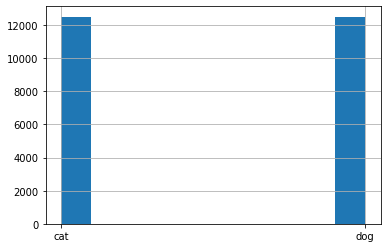

In [19]:
df['label'].hist()

(-0.5, 446.5, 335.5, -0.5)

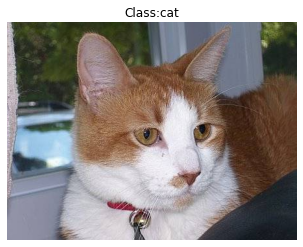

In [20]:
sample = np.random.randint(len(df))

img_path = train_dir_file + df['file'][sample]
label    = df['label'][sample]

img = Image.open(img_path)

plt.imshow(img)
plt.title(f"Class:{label}")
plt.axis('off')

In [21]:
df.shape

(25000, 2)

In [22]:
train_df, valid_df = train_test_split(df, test_size = 0.15)

In [23]:
print("Train set:", train_df.shape)
print("Validation set:", valid_df.shape)

Train set: (21250, 2)
Validation set: (3750, 2)


In [24]:
train_df.head()

file label
21461  dog.6813.jpg   dog
19779    dog.53.jpg   dog
15424   dog.138.jpg   dog
10455  cat.8158.jpg   cat
3211   cat.1638.jpg   cat

In [25]:
test_images_path = os.listdir(test_dir)
test_df = pd.DataFrame({'file':test_images_path})
test_df.head()

file
0      1.jpg
1     10.jpg
2    100.jpg
3   1000.jpg
4  10000.jpg

In [26]:
BATCH_SIZE = 32
IMG_SHAPE = 150 # square image

In [27]:
#generators

#prevent memorization
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )
validation_image_generator = ImageDataGenerator(
    rescale=1./255)

test_image_generator = ImageDataGenerator(
    rescale=1./255)

In [28]:
train_data_gen = train_image_generator.flow_from_dataframe(train_df,
                                                            batch_size=BATCH_SIZE,
                                                            directory=train_dir,
                                                            shuffle=True,
                                                            target_size=(IMG_SHAPE, IMG_SHAPE),
                                                            class_mode='categorical',
                                                            x_col = 'file', 
                                                            y_col = 'label'
                                                            )
                                                           

val_data_gen = validation_image_generator.flow_from_dataframe(valid_df,
                                                            batch_size=BATCH_SIZE,
                                                            directory=train_dir,
                                                            shuffle=False,
                                                            target_size=(IMG_SHAPE, IMG_SHAPE),
                                                            class_mode='categorical',
                                                            x_col='file',
                                                            y_col='label'
                                                            )

test_data_gen = test_image_generator.flow_from_dataframe(test_df,
                                                            batch_size=BATCH_SIZE,
                                                            directory=test_dir,
                                                            shuffle=False,
                                                            class_mode=None,
                                                            target_size=(IMG_SHAPE, IMG_SHAPE),
                                                            color_mode='rgb',
                                                            x_col='file',
                                                            y_col='None'
                                                            )

Found 21250 validated image filenames belonging to 2 classes.
Found 3750 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


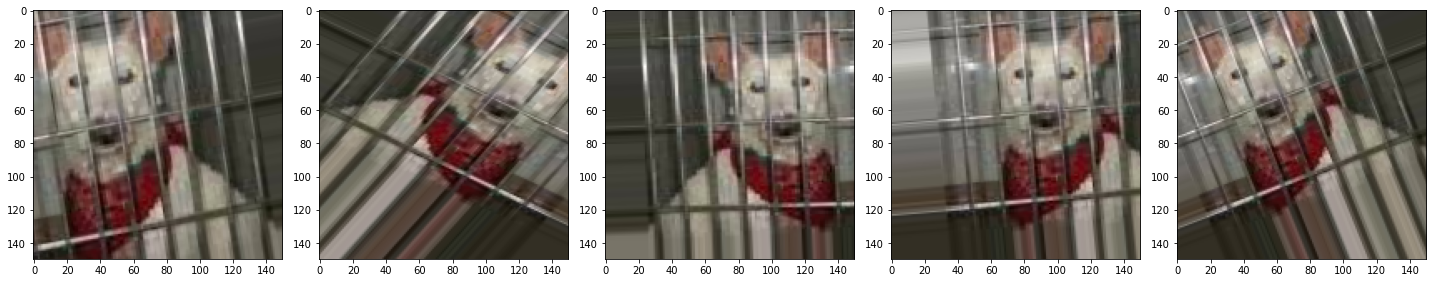

In [30]:
images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(images)

(32, 150, 150, 3)


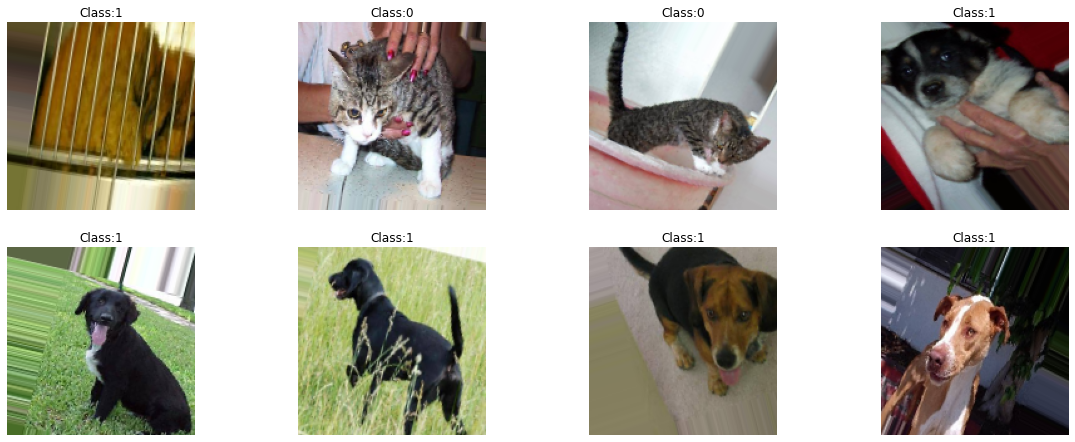

In [36]:
n_samples = 8

plt.figure(figsize=(20,20))
for x_gens, y_gens in train_data_gen:
#     the first dimension of x_gens and y_gens will be equal to batch_size specifed previously
    print(x_gens.shape)
    i = 0
    for sample_img, sample_class in zip(x_gens, y_gens):
        
        plt.subplot(5,4,i+1)
        plt.title(f'Class:{np.argmax(sample_class)}')
        plt.axis('off')
        plt.imshow(sample_img)
        
        i += 1
        
        if i >= n_samples:
            break
    break

In [17]:
# model
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu',
    input_shape=(IMG_SHAPE, IMG_SHAPE, 3)), #RGB
    keras.layers.MaxPooling2D(2,2),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5), # 1/2 of neurons will be turned off randomly

     #[1] or [0] for dogs and cats
    keras.layers.Dense(2, activation='softmax')

])

In [18]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [19]:

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 64)        2

In [20]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# To stop the training after N epochs and val_loss value not decreased
earlystop = EarlyStopping(patience=2)
# To reduce the learning rate when the accuracy not increase for 5 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

# callbacks = [earlystop, learning_rate_reduction]
callbacks = [earlystop]

In [21]:
EPOCHS = 10

In [ ]:
history = model.fit_generator(
            train_data_gen,
            steps_per_epoch=len(train_df) //(BATCH_SIZE),
            validation_steps=len(valid_df) //(BATCH_SIZE),
            # steps_per_epoch=100,
            # validation_steps=50,
            epochs = EPOCHS,
            validation_data=val_data_gen
)


In [38]:
# model.save("model5.h5")
# model.save_weights('weights_v3.h5')
# model =  keras.models.load_model("model5.h5")
# model =  keras.models.load_model("model87.h5")

In [ ]:
# # convert the history.history dict to a pandas DataFrame:     
# hist_df = pd.DataFrame(history.history) 

# # or save to csv: 
# hist_csv_file = 'history.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

In [ ]:
# np.save('history87.npy',history.history)

# history=np.load('history5.npy',allow_pickle='TRUE').item()


In [ ]:
# model.save("fastM.h5")
# model =  load_model("fastM.h5")
# model.summary()

In [39]:
predictions = model.predict(test_data_gen)
predictions = np.argmax(predictions,axis=1)
predictions.shape


(12500,)

In [ ]:
print("Accuracy = ", history.history['accuracy'][-1])
print("Val. Accuracy = ", history.history['val_accuracy'][-1])

In [ ]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc , label='Tran Set')
plt.plot  ( epochs, val_acc , label='Validate Set')
plt.legend()
plt.title ('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss , label='Train Set')
plt.plot  ( epochs, val_loss , label='Validate Set')
plt.legend()
plt.title ('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')


In [ ]:
# random 1 sample from test data set
test_sample = np.random.randint(len(test_df))

test_img_path = test_dir_file + test_df['file'][test_sample]

img = Image.open(test_img_path)
names = lambda x:"class:1 - DOG" if x else "class:0 - CAT"
plt.title(names(predictions[test_sample]))
plt.imshow(img)
plt.axis('off')

[7698, 12464, 3148, 8279, 2697, 7878, 381, 7886]


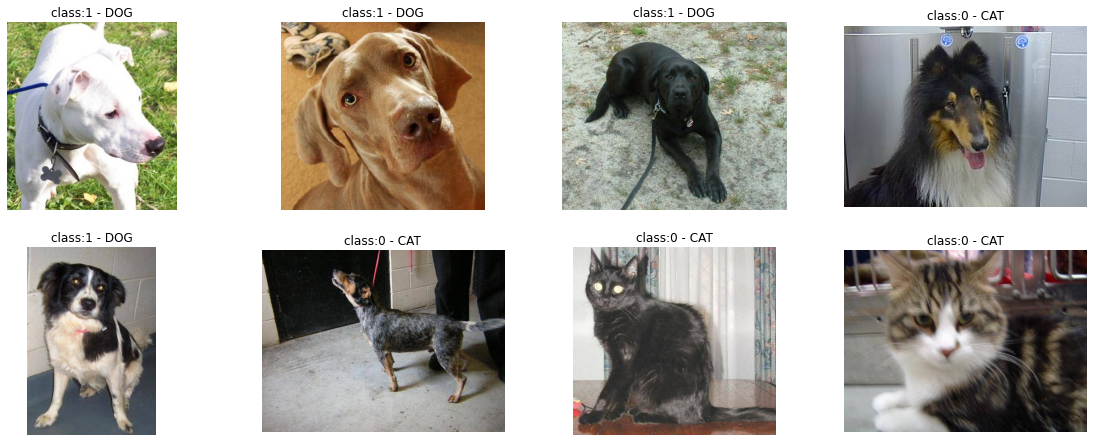

In [67]:
# Prediction from test subset
tstSet = [np.random.randint(1,len(test_df)) for x in range(8)]
print(tstSet)
plt.figure(figsize=(20,20))
for i, j in enumerate (tstSet):
    test_img_path = test_dir_file + test_df['file'][j]
    # fileName = str(test_dir_file+str(j)+".jpg")
    # img = Image.open(fileName)
    img = Image.open(test_img_path)
    plt.subplot(5,4,i+1)
    plt.imshow(img)
    names = lambda x:"class:1 - DOG" if x else "class:0 - CAT"
    plt.title(names(predictions[j]))
    plt.axis('off')

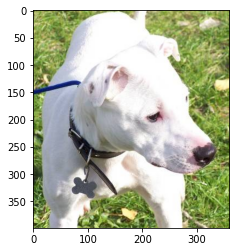

In [75]:
# testA = test_df['file'][7]
# intA = int(testA.split(".")[0])
# print(intA)
j = 7698
test_img_path = test_dir_file + test_df['file'][j]
ima = Image.open(test_img_path)
plt.imshow(ima)

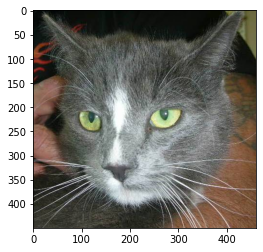

In [76]:
im=Image.open("./ALLDATA/test1/7698.jpg")
plt.imshow(im)

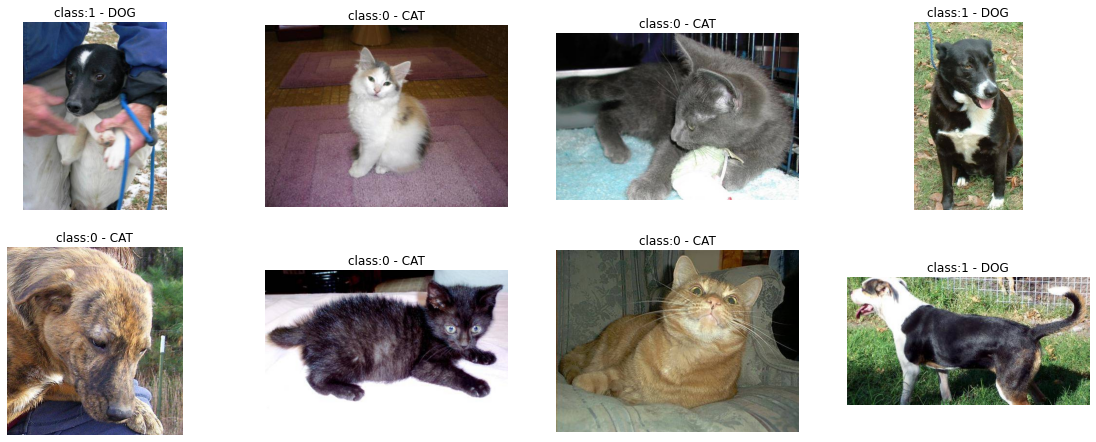

In [66]:
# Prediction from test subset

nsamples = 8
plt.figure(figsize=(20,20))
for i, file in enumerate(test_df['file'][:nsamples]):
    # test_img_path = test_dir_file + test_df['file'][i]
    # img = Image.open(test_img_path)
    # img = Image.open(test_dir_file+file)
    plt.subplot(5,4, i+1)
    plt.imshow(img)
    # idx = int(file.split('.')[0])
    # print("file", file)
    # print("idx", idx)
    # plt.title(f"Class:{className(predictions[i])}")
    names = lambda x:"class:1 - DOG" if x else "class:0 - CAT"
    plt.title(names(predictions[i]))
    plt.axis('off')

C:\Users\Shatsuku\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(-0.5, 149.5, 149.5, -0.5)

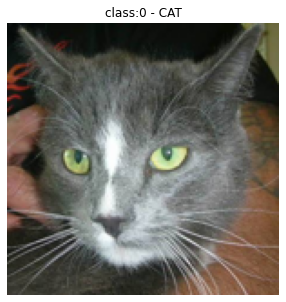

In [68]:
# Test on custom data

Image_Width=150
Image_Height=150
Image_Size=(Image_Width,Image_Height)

plt.figure(figsize=(5,5))
# im=Image.open("./ALLDATA/ar.jpg")
im=Image.open("./ALLDATA/test1/7698.jpg")
im=im.resize(Image_Size)
plt.imshow(im)
# pre-processing
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255.
pred=model.predict_classes([im])[0]
names = lambda x:"class:1 - DOG" if x else "class:0 - CAT"
plt.title(names(pred))
plt.axis('off')